In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys, re
from tqdm.notebook import tqdm

In [2]:
regex= re.compile(r'\d+')

In [3]:
data_folder = os.path.join('/','Users', 'cdesio', 'UoB', 'leakage')

In [4]:
extracted_folder = os.path.join(data_folder, 'extracted')

In [5]:
fnames = os.listdir(extracted_folder)

In [6]:
Temps = []
Tints = []
for fname in fnames:
    split = fname.split('_')
    T = split[0]
    tint = split[1]
    Temps.append(float(T[1:]))
    Tints.append(int(regex.findall(tint)[0]))
    

In [7]:
def sel_files(flist, ts=None):
    selected = []
    if len(ts)>0:
        for t in ts:
            for f in flist:
                if str(t) in f:
                    selected.append(f)
    return sorted(selected)

In [8]:
file_list = set(sel_files(fnames, ts = np.unique(Tints)))-set([])

In [9]:
def bad_pixel_mask(array):
    mean = np.mean(array)
    if np.any(array)<= mean-2000:
        bad = np.where(array<=mean-2000)[0]
        for pix in bad:
            if pix<len(array)-1:
                array[pix] = np.mean([array[pix-1], array[pix+1]])
            else:
                array[pix]=array[pix-1]
    if np.any(array)>= mean+2000:
        bad_up = np.where(array>=mean+2000)[0]
        for px in bad_up:
            if px<len(array)-1:
                array[px] = np.mean([array[px-1], array[px+1]])
            else:
                array[px] = array[px-1]
    return array

In [23]:
def ravel_nested(ax):
    return np.vstack(ax).reshape(20, 400)

mean_pix_by_pix = np.empty((129,20))
std_pix_by_pix = np.empty((129,20))
temps = np.zeros((129,20))
tints = np.zeros((129,20))
for i,f in tqdm(enumerate(file_list), desc='file'):
    temps[i] = np.tile(np.float(f.split('_')[0][1:]),20)
    tints[i] = np.tile(int(regex.findall(f.split('_')[1])[0]),20)
    imported = np.load(os.path.join(extracted_folder,f), allow_pickle=True)['pixels']
    stacked = np.apply_along_axis(ravel_nested, 1, imported)
    corrected = np.apply_along_axis(bad_pixel_mask, 0, stacked)
    mean_pix_by_pix[i]= np.mean(np.mean(corrected, axis=0), axis=1)
    std_pix_by_pix[i]= np.mean(np.std(corrected, axis=0), axis=1)/20.
    #std_pix_by_pix[i]= np.sqrt(np.sum(corrected[i]**2, axis=1))/400.

In [24]:
rad_dam = np.array([50, 45, 40, 35, 30, 20, 18, 16, 14, 12, 10, 9, 8, 25, 6, 5, 4, 3, 2, 1])

In [25]:
rad_dam = np.tile(rad_dam, 129).reshape(129, 20)

In [26]:
df = pd.DataFrame({"T":temps.ravel(), "tint":tints.ravel(), 'rad_dam':rad_dam.ravel(), 
                   'pedestal': mean_pix_by_pix.ravel(), 'noise':std_pix_by_pix.ravel()})

In [27]:
df.head(n=3)

,T,tint,rad_dam,pedestal,noise
0,0.1,13676832.0,50,16058.376875,0.067634
1,0.1,13676832.0,45,16046.216212,0.061658
2,0.1,13676832.0,40,16046.339150,0.058676


In [28]:
np.unique(df['T'])

array([-20. , -15. , -10. ,  -5. ,   0.1,   4.9,  10. ,  14.9,  20. ,
        24.8,  30. ])

mean_pix_by_pix = np.zeros((129,200, 20, 400))
rad_dam = [50, 45, 40, 35, 30, 20, 18, 16, 14, 12, 10, 9, 8, 25, 6, 5, 4, 3, 2, 1]
for i,f in tqdm(enumerate(file_list), desc='file'):
    #print(f)
    te = np.float(f.split('_')[0][1:])
    tint = int(regex.findall(f.split('_')[1])[0])
    imported = np.load(os.path.join(extracted_folder,f), allow_pickle=True)['pixels']
    
    for fn, f in enumerate(imported):
        iter_rad_dam = iter(rad_dam)
        
        for j, r in enumerate(f):
            mean_pix_by_pix[i,fn,j]=np.ravel(r)
            label=next(iter_rad_dam)
            #print(test.shape)
            #pixels[i, j] = (label, te, tint, np.mean(np.mean(test, axis=0), axis=1), np.mean(np.std(test, axis=0), axis=1))

In [29]:
ttints = []
Temps = []
rads = []
intensities = []
errors = []
for (T,r,t), group in df[(df['rad_dam']<15) & (df['T'].isin([-20.0, -10.0, 0.1, 10.0, 14.9]))].groupby(['T', 'rad_dam', 'tint']):
    #print(T,r,t,float(group['noise']), float(group['pedestal']))
    Temps.append(T)
    ttints.append(t)
    rads.append(r)
    intensities.append(float(group['pedestal']))
    errors.append(float(group['noise']))

In [30]:
ttints = np.array(ttints)
Temps = np.array(Temps)
rads = np.array(rads)
intensities = np.array(intensities)
errors = np.array(errors)

In [41]:
intensities[np.argwhere(rads==r).ravel()][np.where(Temps[np.argwhere(rads==r).ravel()]==t)[0]]

array([ 9389.23975  , 11172.08845  , 14794.2721   , 16356.4684875,
       16371.4469875, 16372.89185  , 16373.68285  , 16373.1452375,
       16372.9993625, 16373.0665625])

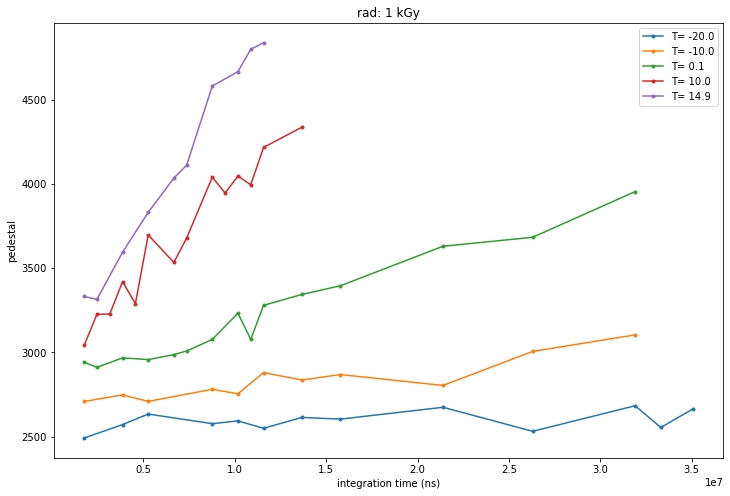

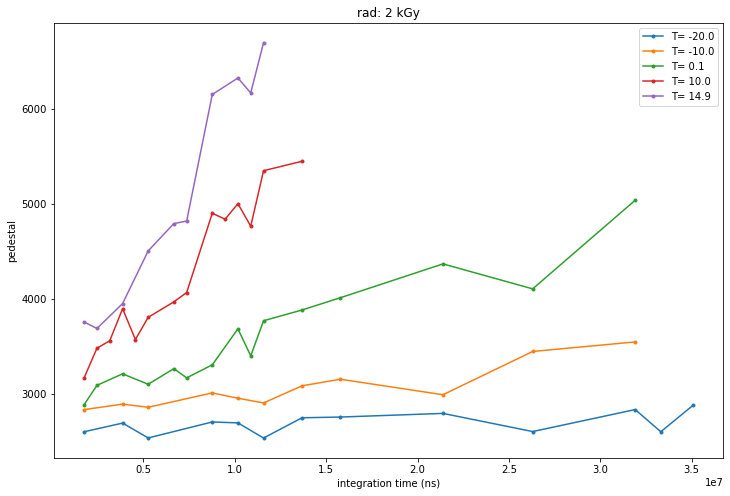

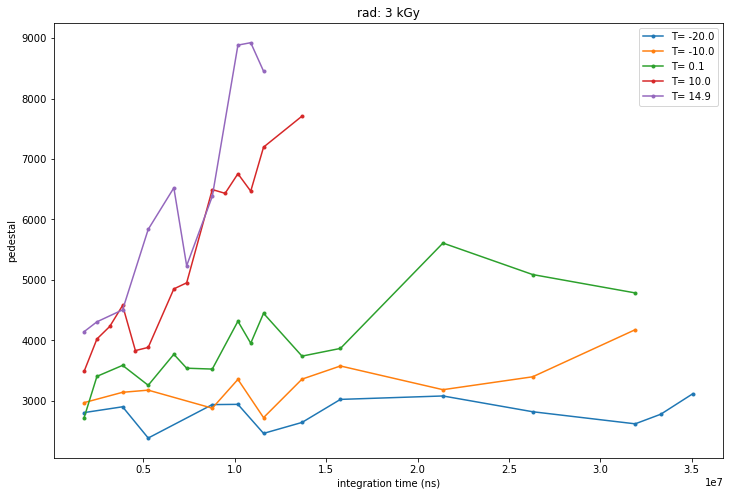

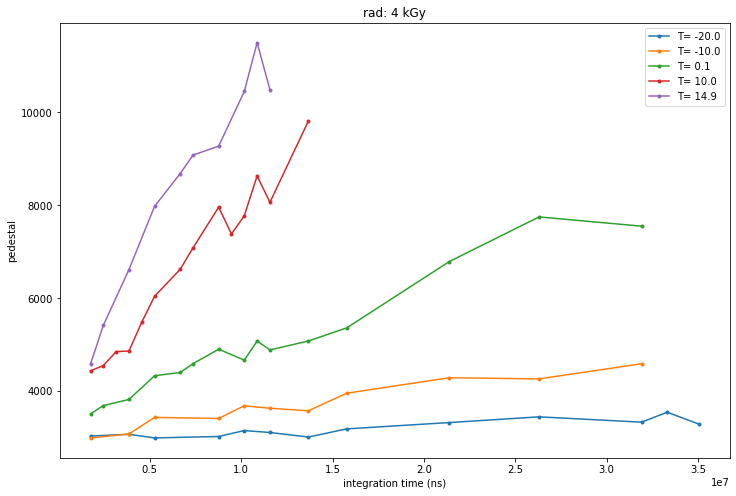

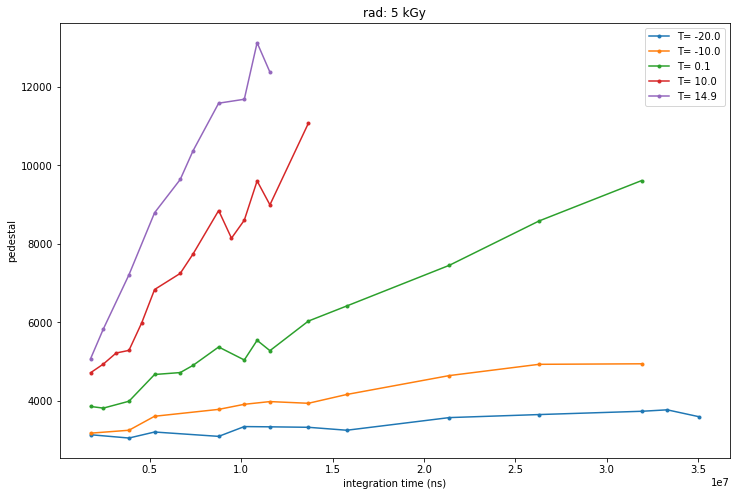

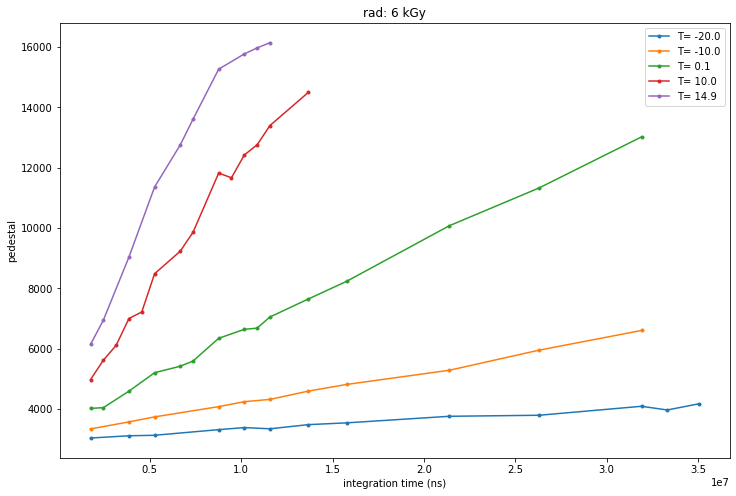

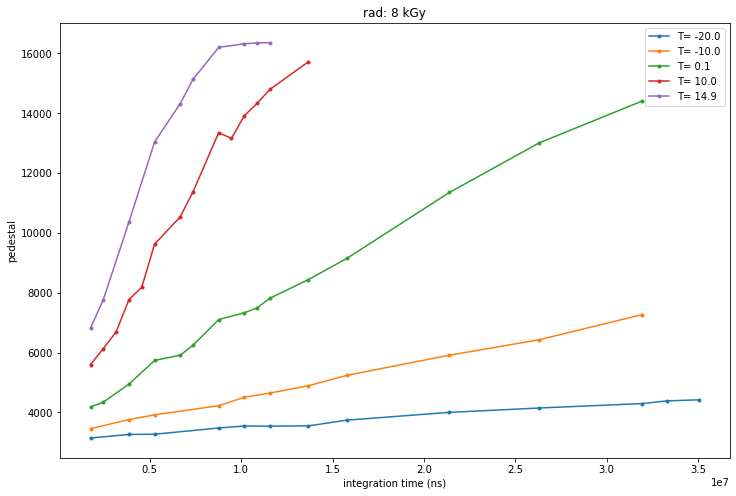

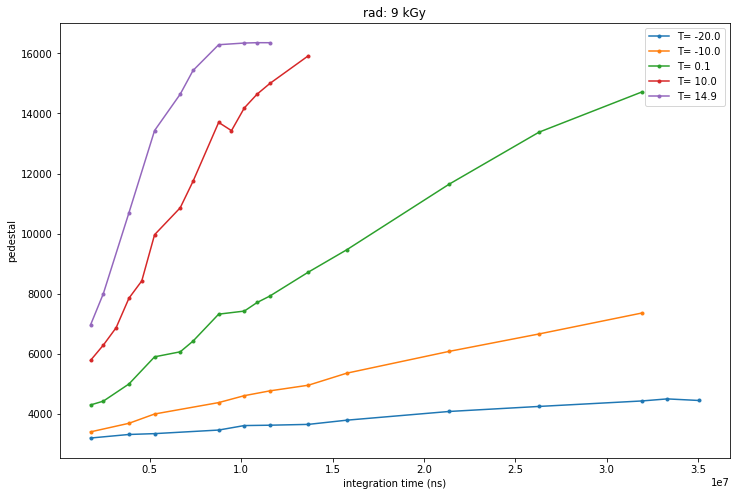

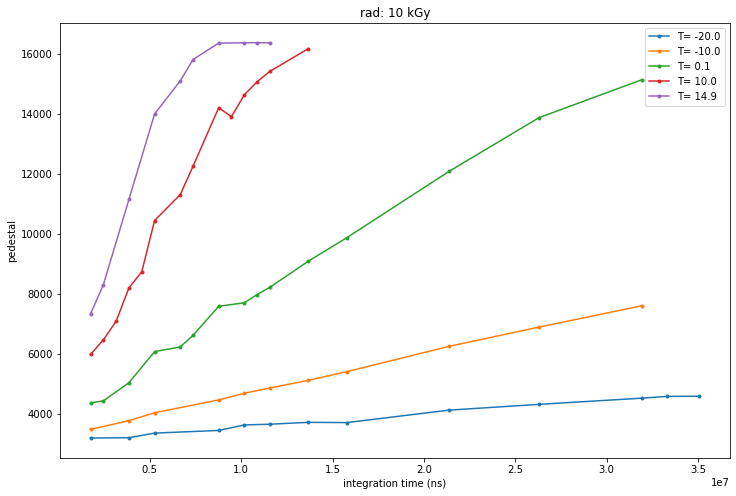

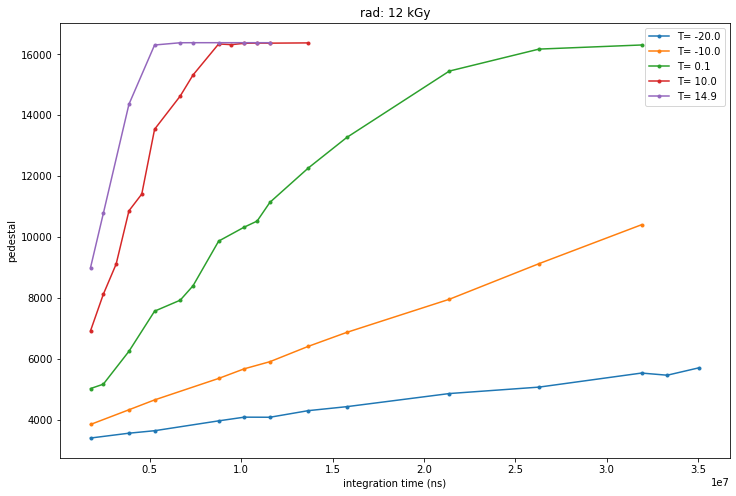

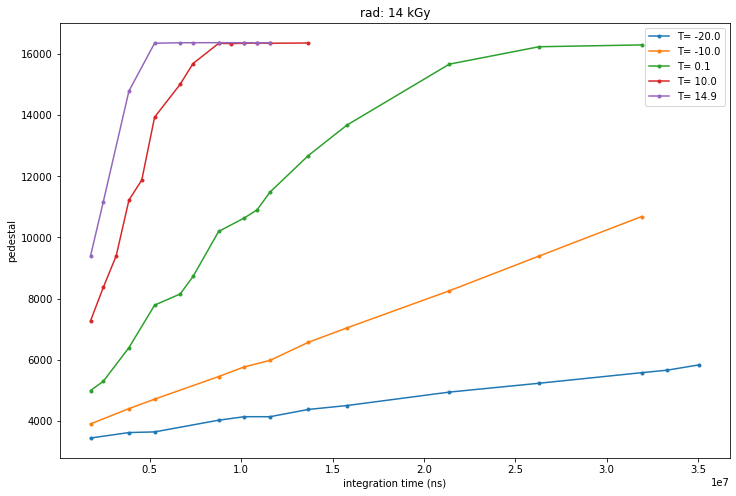

In [38]:
for r in np.unique(rads):
    plt.figure(figsize=(12,8))
    for t in np.unique(Temps):
        plt.plot(ttints[np.argwhere(rads==r).ravel()][np.where(Temps[np.argwhere(rads==r).ravel()]==t)[0]], 
                 intensities[np.argwhere(rads==r).ravel()][np.where(Temps[np.argwhere(rads==r).ravel()]==t)[0]],
                 'o-',markersize=3,
                label = 'T= {}'.format(t))
        plt.title('rad: {} kGy'.format(r))
        plt.xlabel('integration time (ns)')
        plt.ylabel('pedestal')
#         plt.ylim(0,3500)
    plt.legend(loc='upper right')
    plt.show()

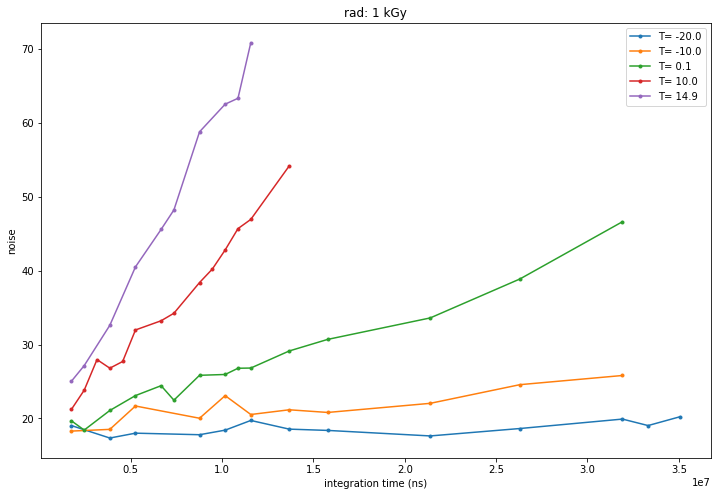

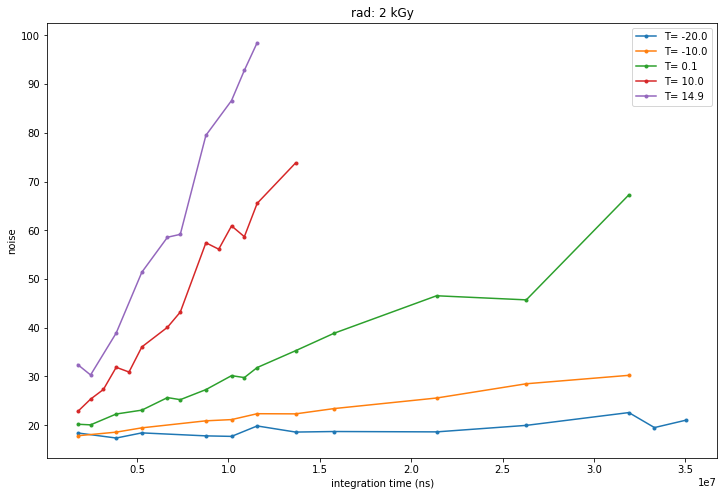

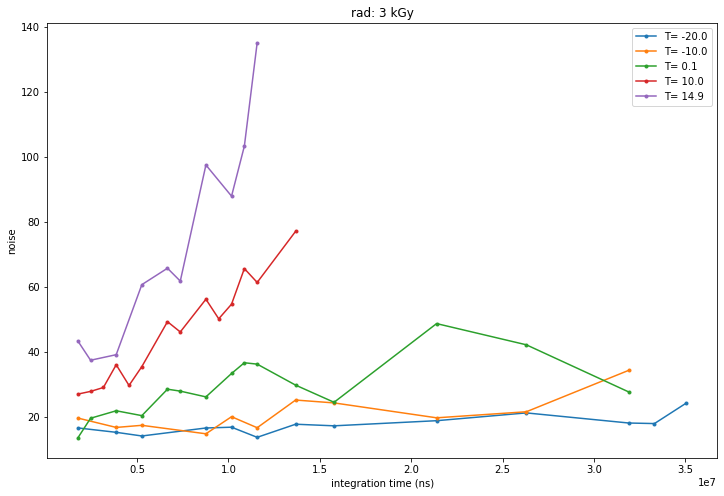

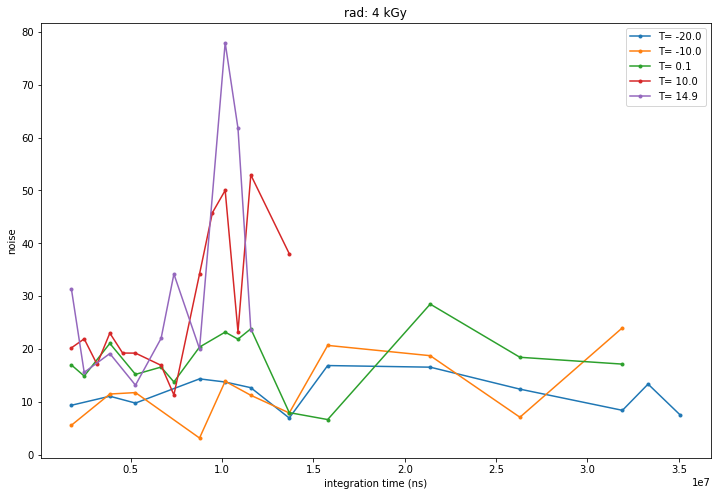

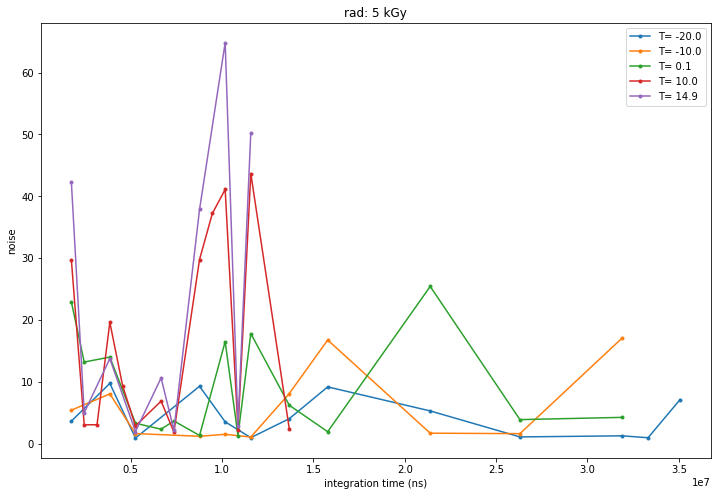

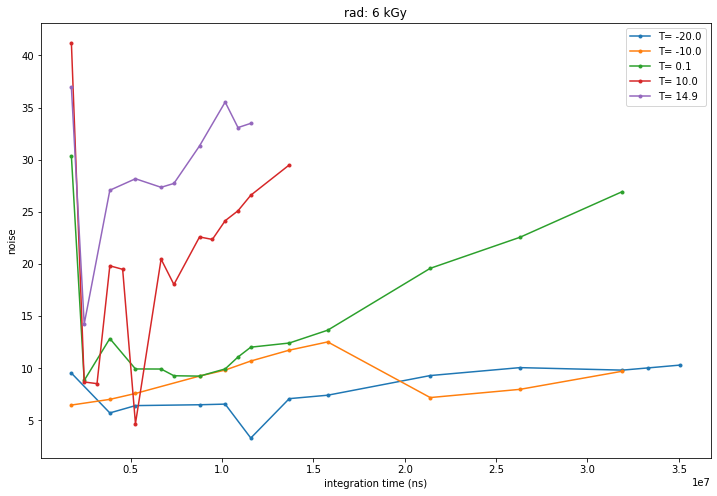

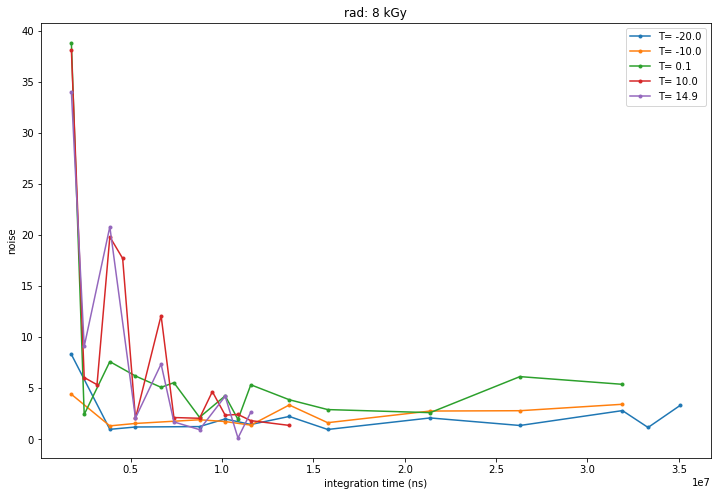

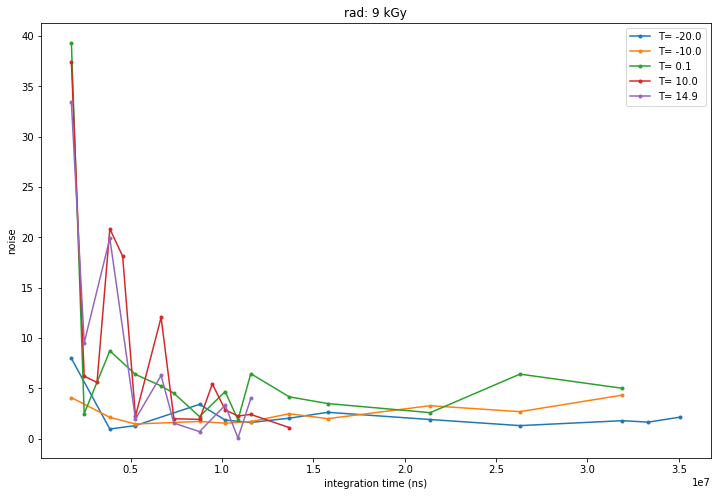

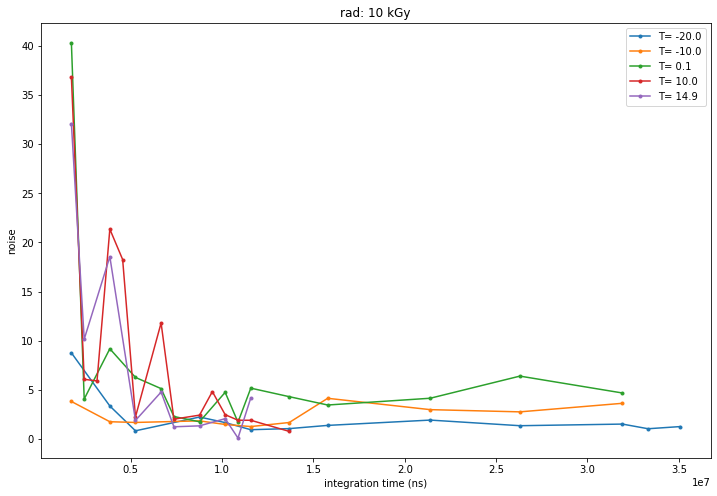

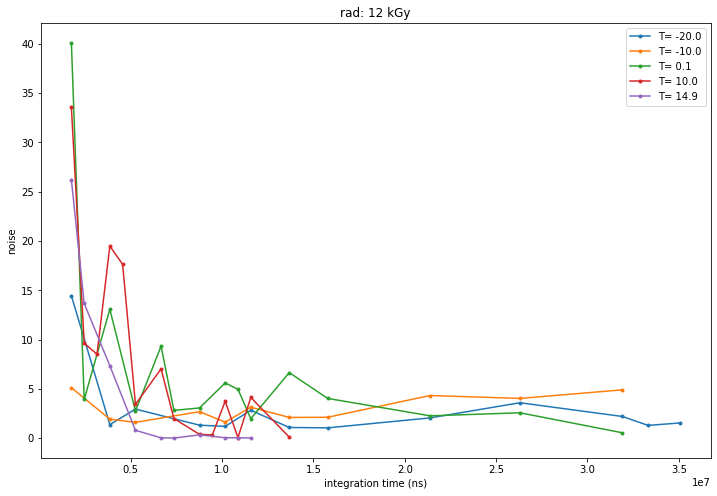

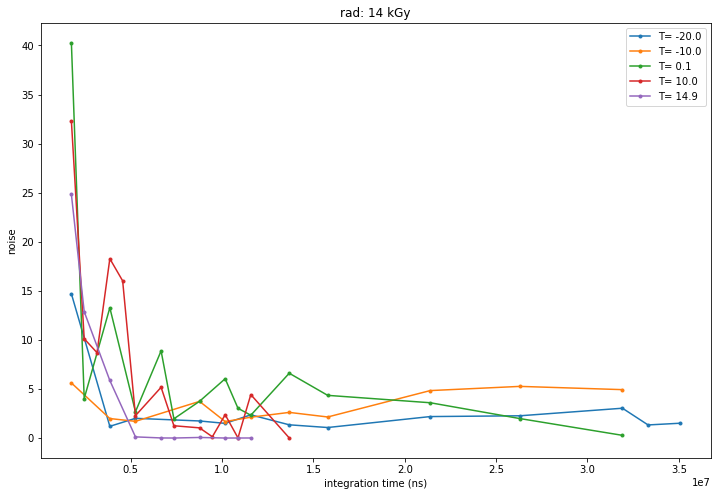

In [31]:
for r in np.unique(rads):
    plt.figure(figsize=(12,8))
    for t in np.unique(Temps):
        plt.plot(ttints[np.argwhere(rads==r).ravel()][np.where(Temps[np.argwhere(rads==r).ravel()]==t)[0]], 
                 errors[np.argwhere(rads==r).ravel()][np.where(Temps[np.argwhere(rads==r).ravel()]==t)[0]],
                 'o-',markersize=3,
                label = 'T= {}'.format(t))
        plt.title('rad: {} kGy'.format(r))
        plt.xlabel('integration time (ns)')
        plt.ylabel('noise')
        #plt.ylim(0,15)
    plt.legend(loc='upper right')
    plt.show()
    #plt.savefig('noise_vs_tint_5_temperatures_{}kGy.png'.format(r))

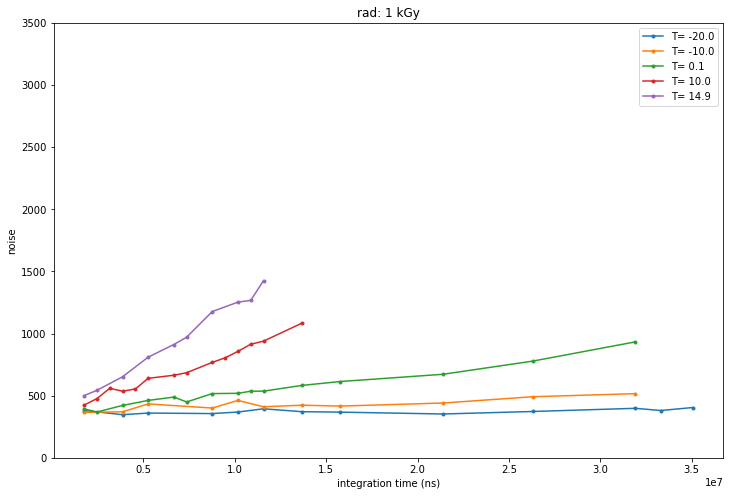

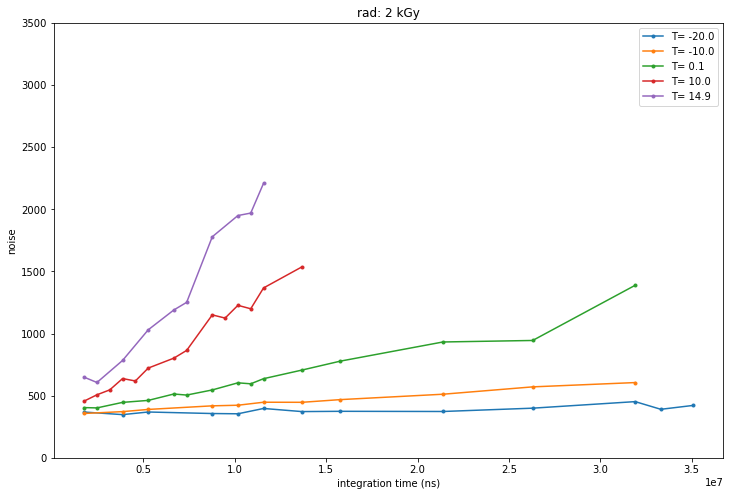

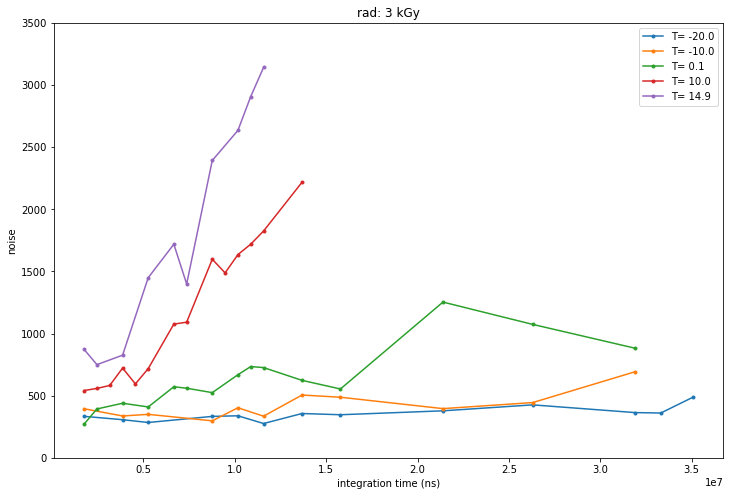

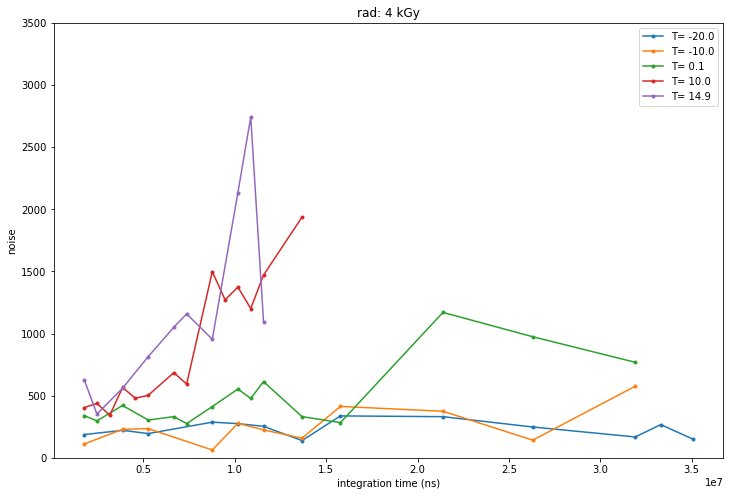

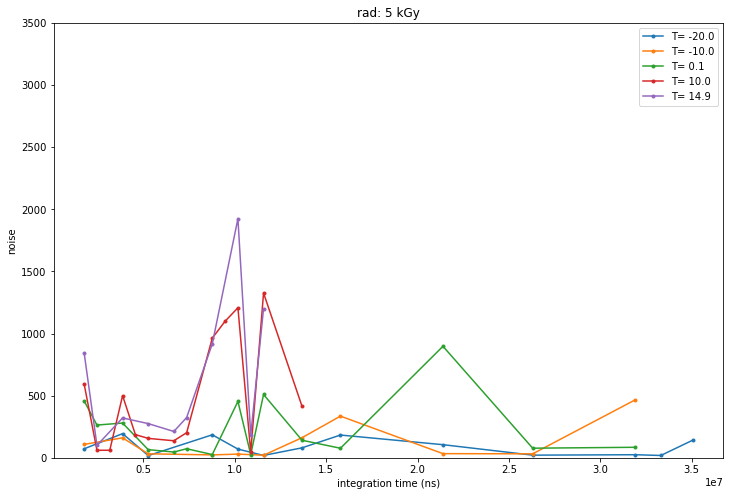

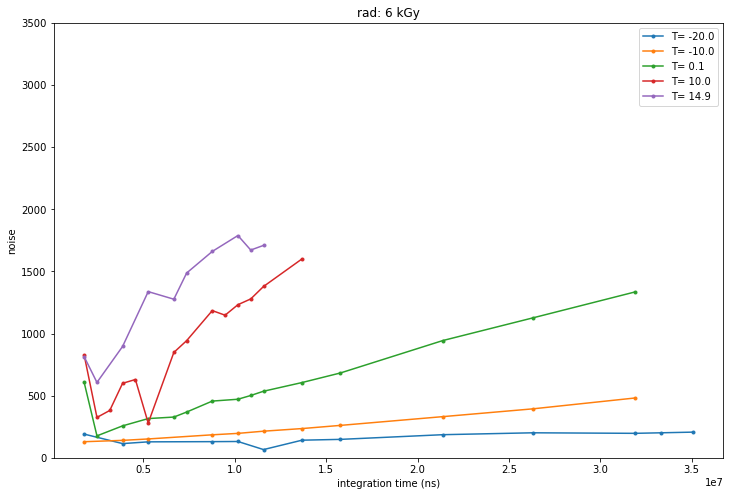

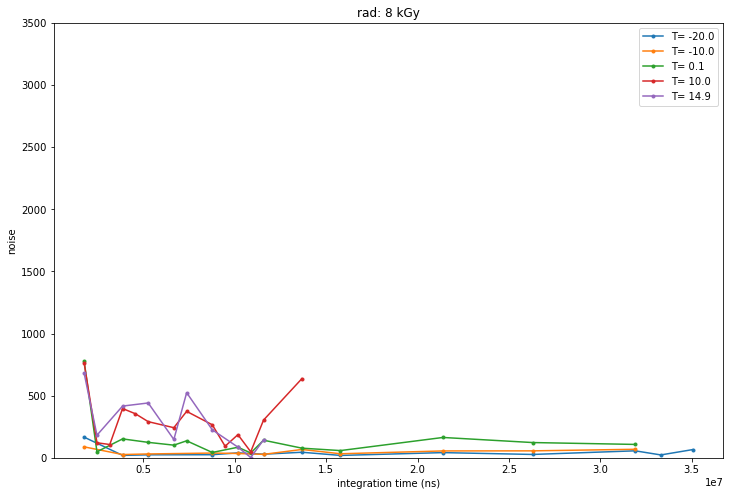

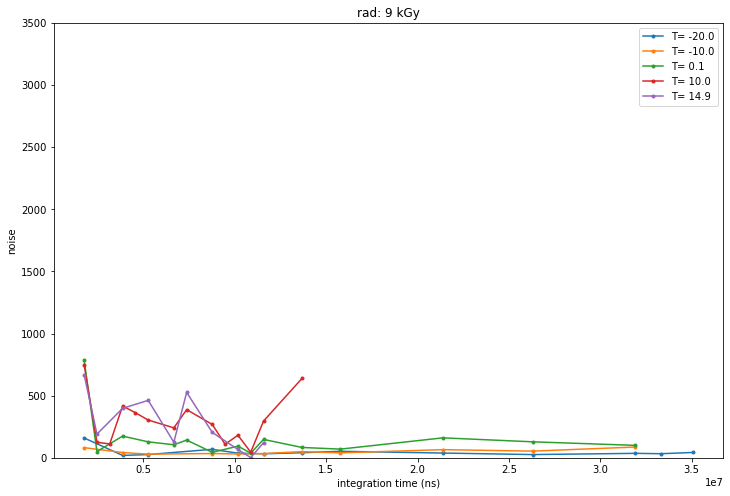

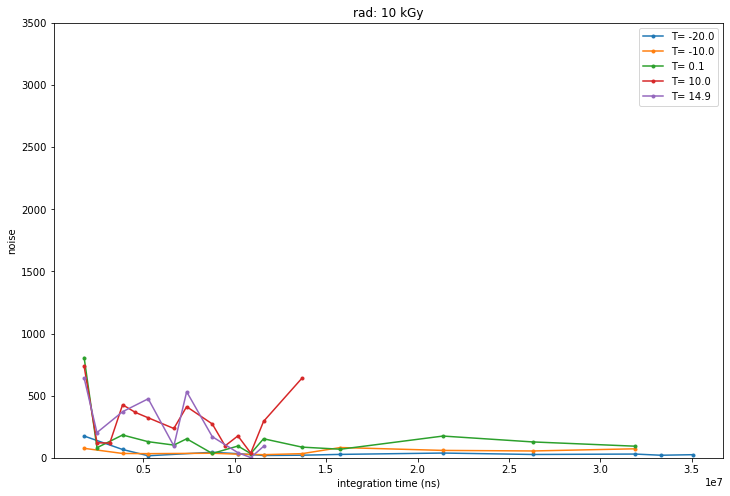

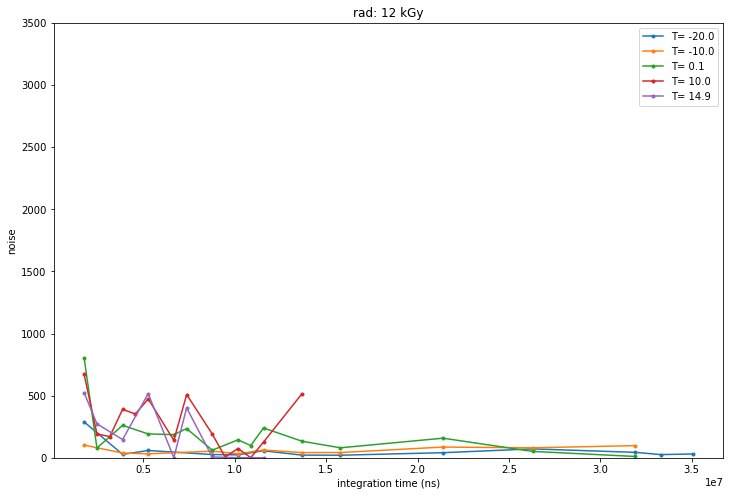

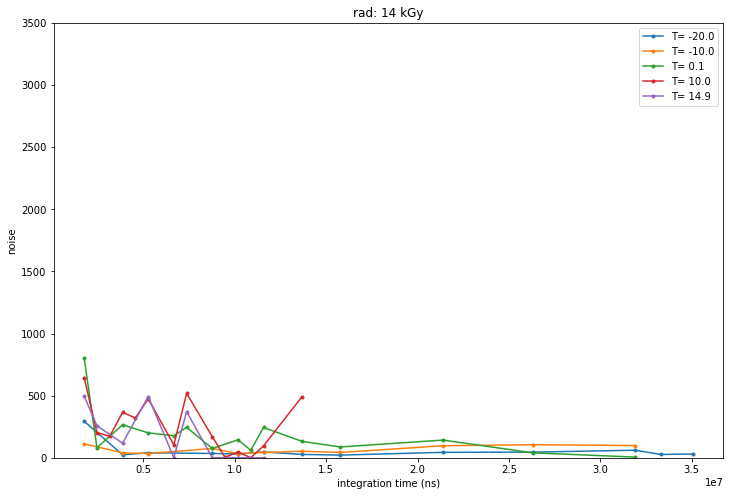

In [239]:
for r in np.unique(rads):
    plt.figure(figsize=(12,8))
    for t in np.unique(Temps):
        
        plt.plot(tints[np.argwhere(rads==r)][np.where(Temps[np.argwhere(rads==r)]==t)[0]], 
                 errors[np.argwhere(rads==r)][np.where(Temps[np.argwhere(rads==r)]==t)[0]],
                 'o-',markersize=3,
                label = 'T= {}'.format(t))
        plt.title('rad: {} kGy'.format(r))
        plt.xlabel('integration time (ns)')
        plt.ylabel('noise')
        plt.ylim(0,3500)
    plt.legend(loc='upper right')
    #plt.show()
    #plt.savefig('noise_vs_tint_5_temperatures_{}kGy.png'.format(r))

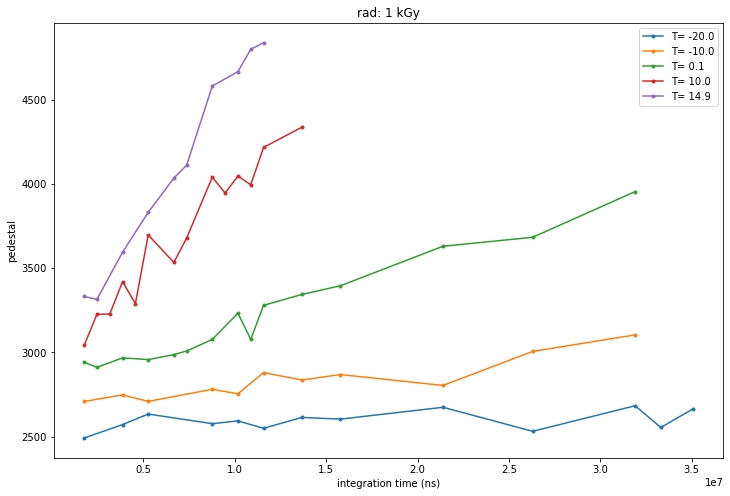

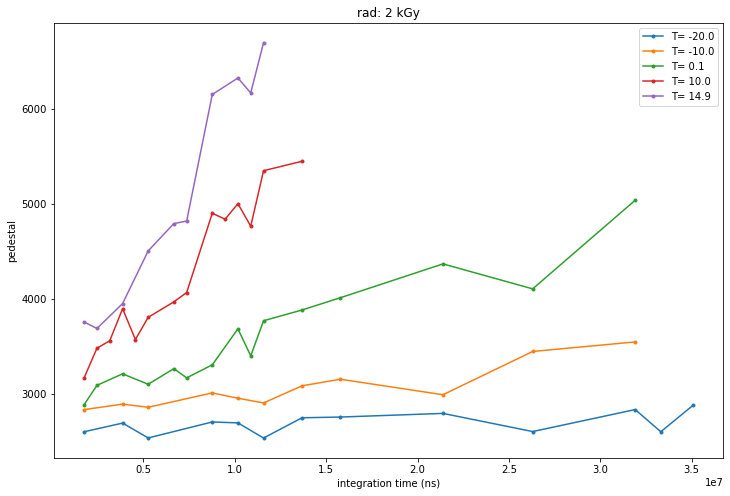

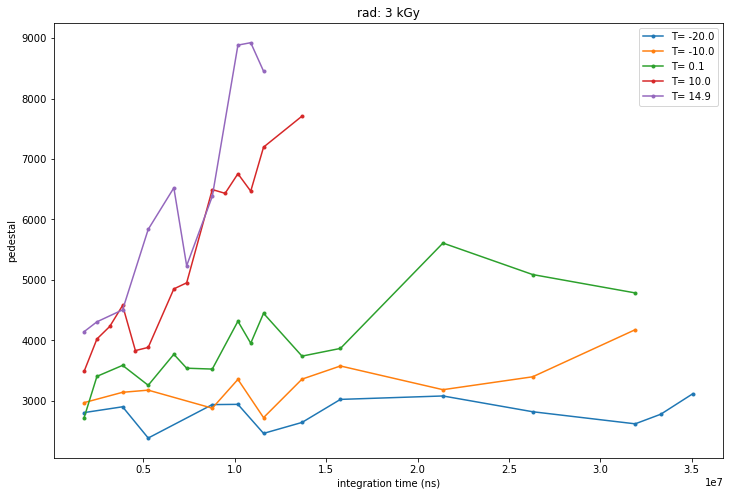

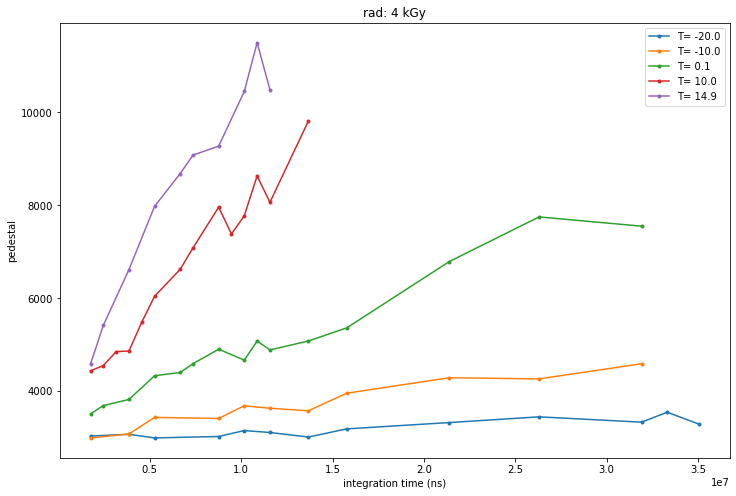

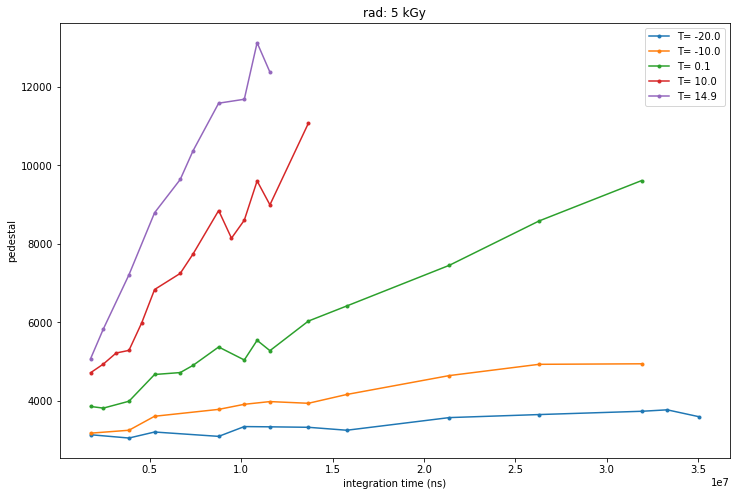

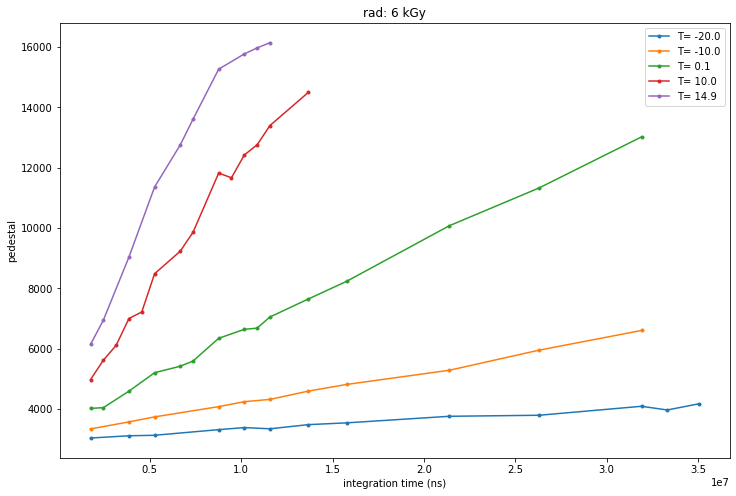

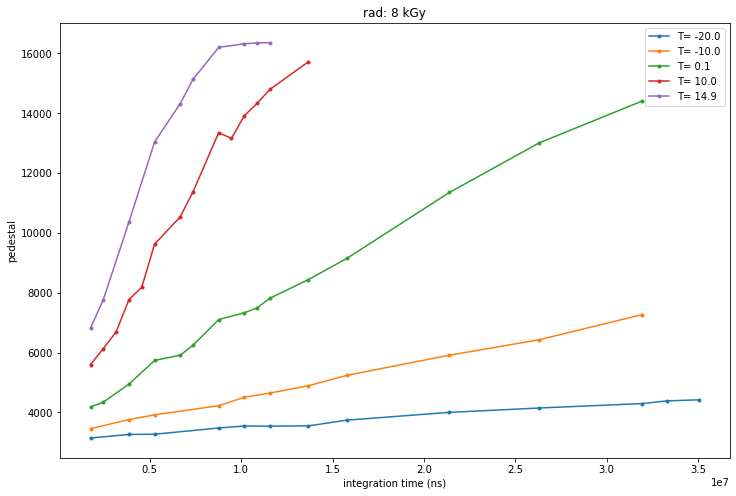

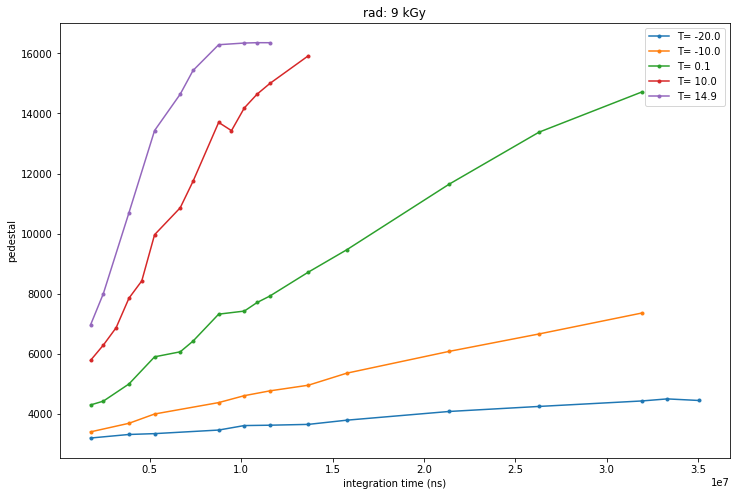

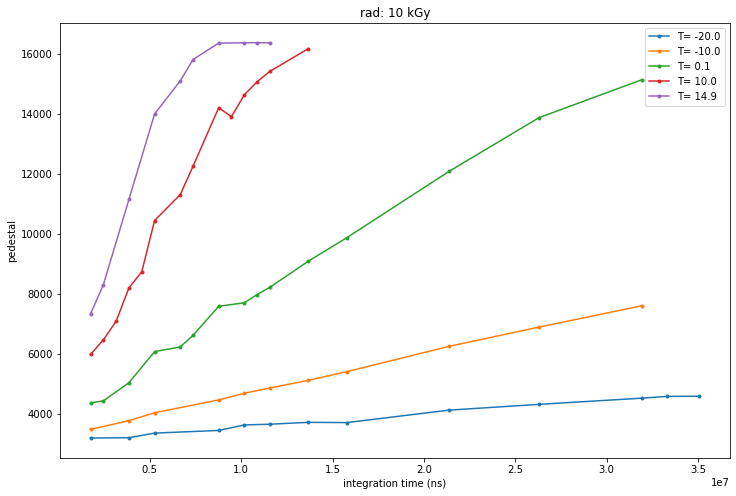

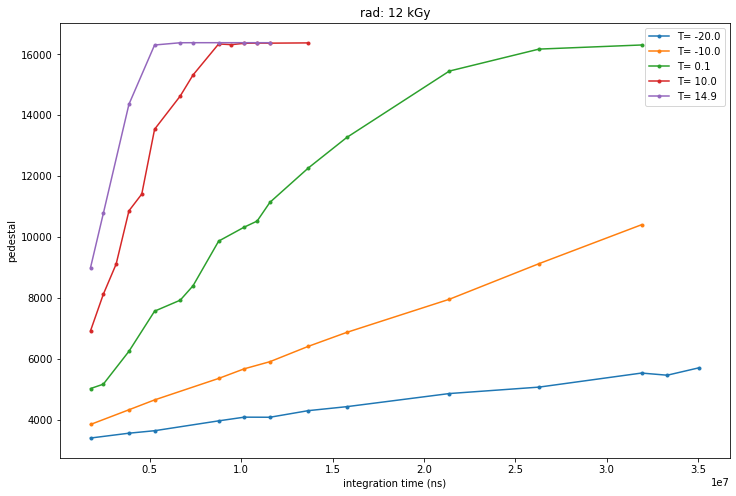

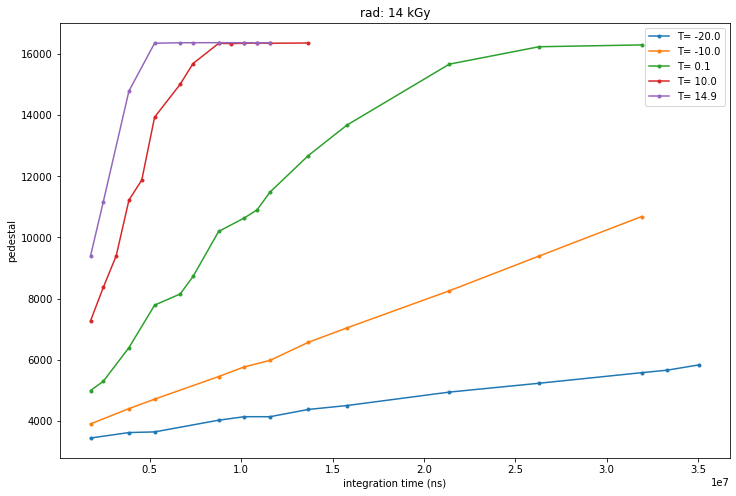

In [102]:
for r in np.unique(rads):
    plt.figure(figsize=(12,8))
    for t in np.unique(Temps):
        
        plt.plot(ttints[np.argwhere(rads==r)][np.where(Temps[np.argwhere(rads==r)]==t)[0]], 
                 intensities[np.argwhere(rads==r)][np.where(Temps[np.argwhere(rads==r)]==t)[0]],
                 'o-',markersize=3,
                label = 'T= {}'.format(t))
        plt.title('rad: {} kGy'.format(r))
        plt.xlabel('integration time (ns)')
        plt.ylabel('pedestal')
        #plt.ylim(0,3500)
    plt.legend(loc='upper right')
    plt.show()

/Users/cdesio/opt/anaconda3/envs/pyroot/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  if __name__ == '__main__':


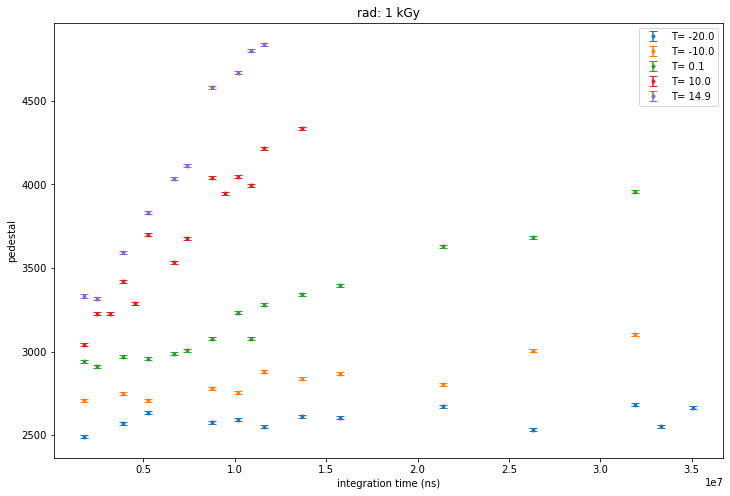

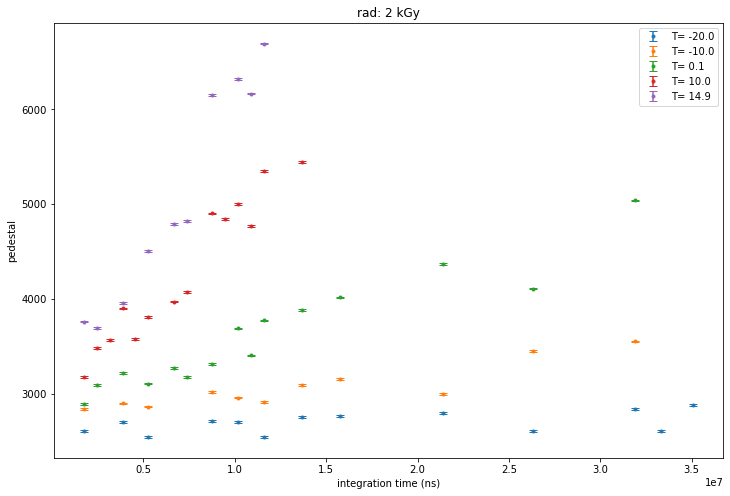

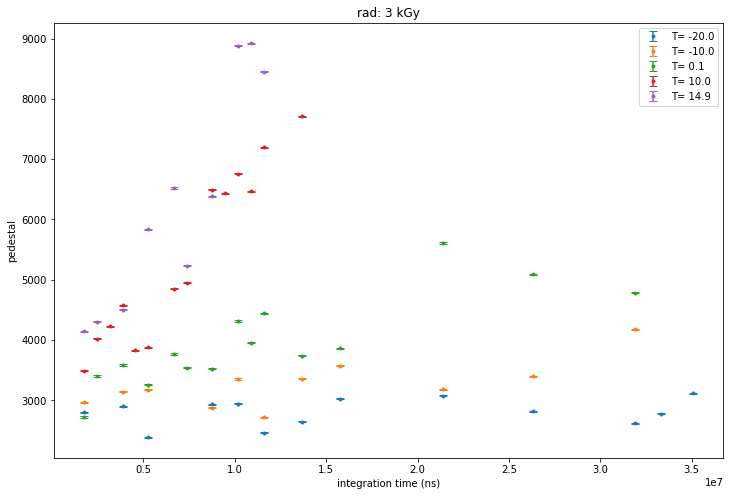

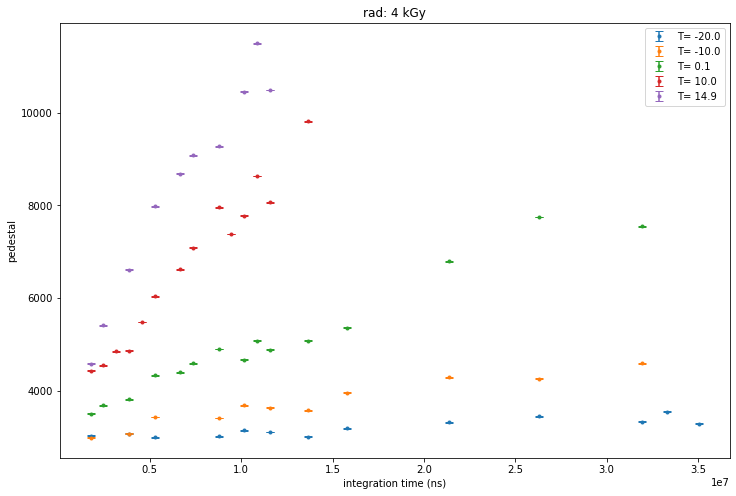

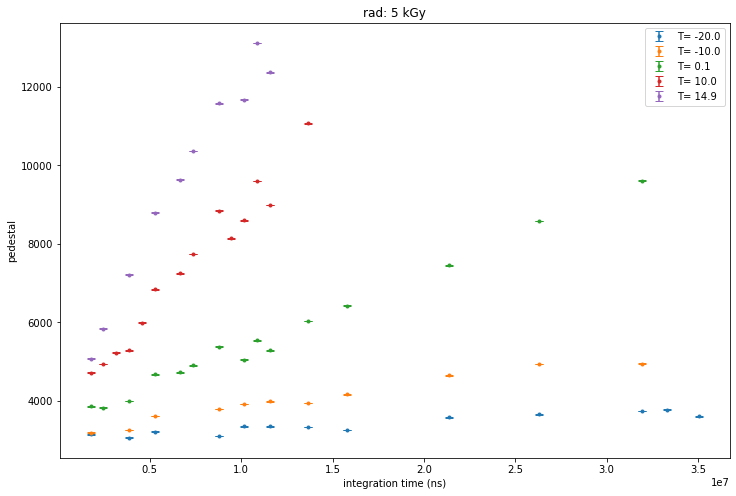

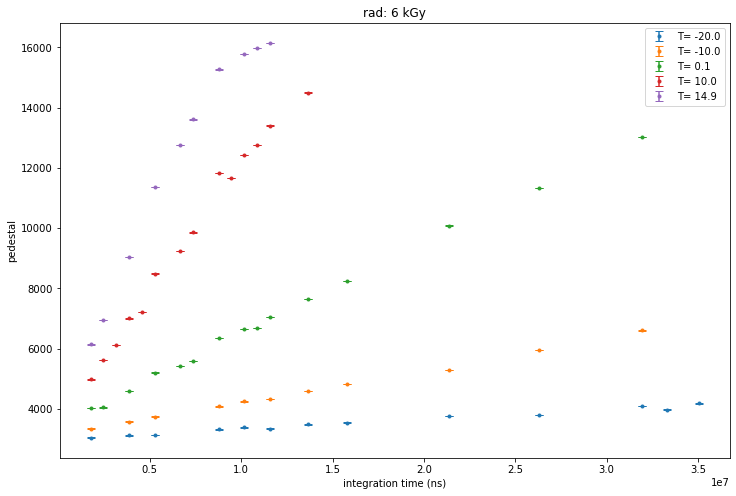

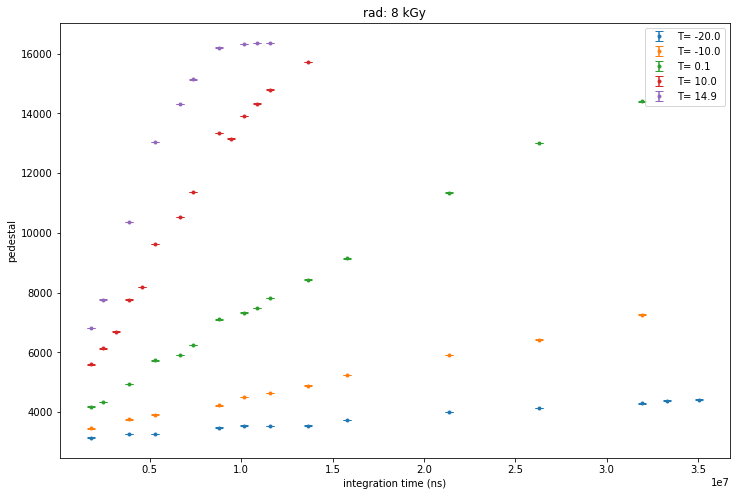

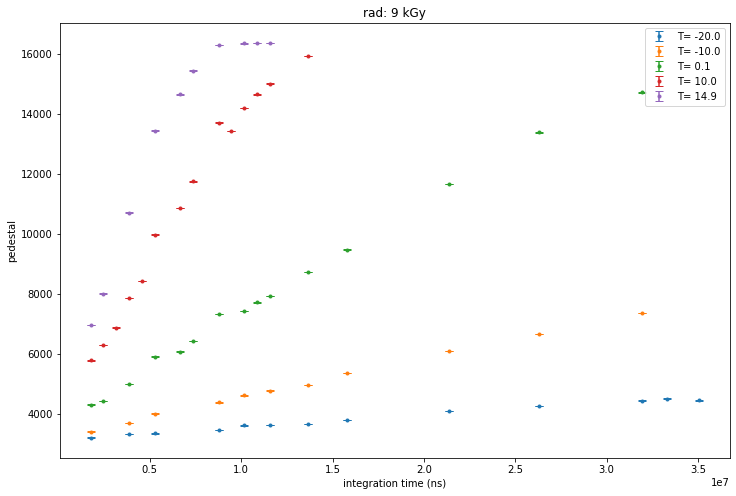

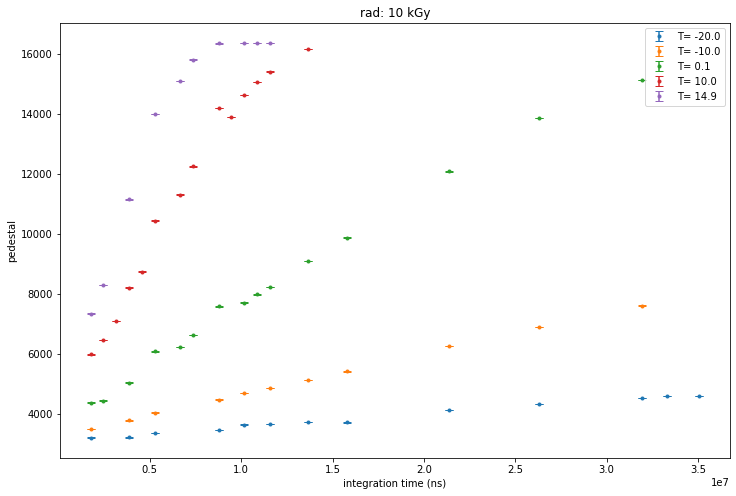

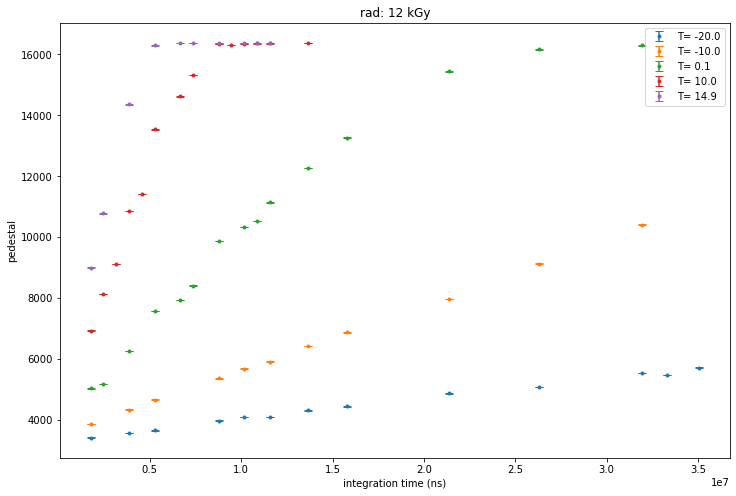

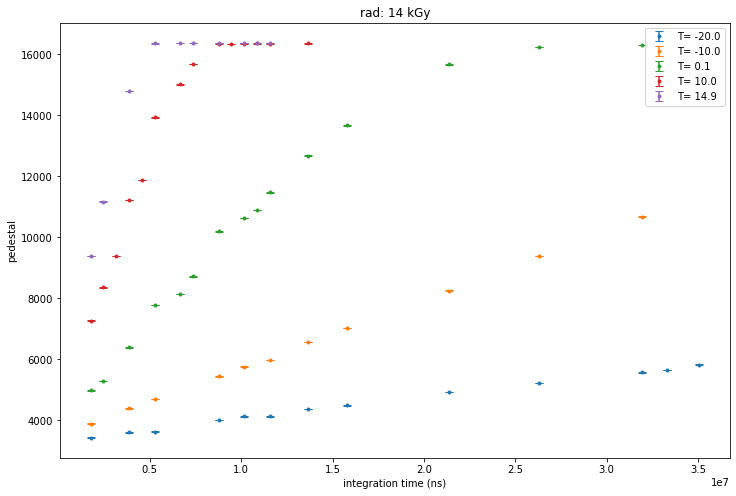

In [22]:
for r in np.unique(rads):
    plt.figure(figsize=(12,8))
    for t in np.unique(Temps):
        
        plt.errorbar(x=ttints[np.argwhere(rads==r)][np.where(Temps[np.argwhere(rads==r)]==t)[0]], 
                 y=intensities[np.argwhere(rads==r)][np.where(Temps[np.argwhere(rads==r)]==t)[0]],
                     yerr = errors[np.argwhere(rads==r)][np.where(Temps[np.argwhere(rads==r)]==t)[0]],
                 markersize=3,capsize=4, fmt='o',
                label = 'T= {}'.format(t))
        plt.title('rad: {} kGy'.format(r))
        plt.xlabel('integration time (ns)')
        plt.ylabel('pedestal')
        #plt.ylim(0,3500)
    plt.legend(loc='upper right')
    #plt.show()
    plt.savefig('pedestal_w_noise_vs_tint_5_temperatures_{}kGy.png'.format(r))